## 验证实验： pbmc 数据看cos夹角

In [1]:
from geneformer import InSilicoPerturber
from geneformer import InSilicoPerturberStats
from geneformer.tokenizer import TOKEN_DICTIONARY_FILE
from datasets import concatenate_datasets
import itertools as it
import logging
import numpy as np
import pickle
import re
import seaborn as sns; sns.set()
import torch
from collections import defaultdict
from datasets import Dataset, load_from_disk
from tqdm.notebook import trange
from transformers import BertForMaskedLM, BertForTokenClassification, BertForSequenceClassification
from collections import OrderedDict
from geneformer.in_silico_perturber import downsample_and_sort, \
                                         gen_attention_mask, \
                                         get_model_input_size, \
                                         load_and_filter, \
                                         load_model, \
                                         pad_tensor_list, \
                                         quant_layers, \
                                         pad_tensor, \
                                                                                                                                                                                                                                                                                                                                                                         forward_pass_single_cell, \
                                         make_perturbation_batch, \
                                         quant_cos_sims, \
                                         make_comparison_batch, \
                                         measure_length, \
                                         delete_indices, \
                                         pad_or_truncate_encoding, \
                                         remove_indices_from_emb_batch, \
                                         get_cell_state_avg_embs, \
                                         overexpress_tokens, \
                                         cos_sim_shift, \
                                         mean_nonpadding_embs

from collections import Counter
import scanpy as sc
import anndata as ad
import pandas as pd
from transformers import Trainer
from geneformer import DataCollatorForCellClassification
from sklearn.metrics import accuracy_score, f1_score
from pandas import Series,DataFrame
import random
logger = logging.getLogger(__name__)

In [12]:
# 需要修改的函数， 在geneformer代码的基础上做的修改，不然代码跑不通
def get_possible_states(cell_states_to_model):
    possible_states = []
    for key in ["start_state","goal_state"]:
        possible_states += [cell_states_to_model[key]]
    return possible_states

def random_select(input, max_sample=500, seed=2023):
    random.seed(seed)
    if len(input) <= max_sample:
        return input
    else:
        random_list = random.sample(list(np.arange(len(input))), max_sample)
        return input.select(random_list)

def cos_sim_shift_ipsc(original_emb, 
                      minibatch_emb, 
                      end_emb, 
                      perturb_group, 
                      original_minibatch_lengths = None, 
                      minibatch_lengths = None,
                      perturb_method = 'cell'):
    cos = torch.nn.CosineSimilarity(dim=2)
    
    if original_emb.size() != minibatch_emb.size():
        logger.error(
            f"Embeddings are not the same dimensions. " \
            f"original_emb is {original_emb.size()}. " \
            f"minibatch_emb is {minibatch_emb.size()}. "
        )
        raise
    
    if perturb_method == 'cell':
        if original_minibatch_lengths is not None:
            original_emb = mean_nonpadding_embs(original_emb, original_minibatch_lengths)
            end_emb = torch.unsqueeze(end_emb, 1)
            origin_v_end = cos(original_emb, end_emb)
            origin_v_end = torch.squeeze(origin_v_end)
        
        if minibatch_lengths is not None:
            perturb_emb = mean_nonpadding_embs(minibatch_emb, minibatch_lengths)
            perturb_v_end = cos(perturb_emb, end_emb)
            perturb_v_end = torch.squeeze(perturb_v_end)
    elif perturb_method == 'gene':
        origin_v_end = cos(original_emb, end_emb)
        perturb_v_end = cos(minibatch_emb, end_emb)
    
    return [(perturb_v_end - origin_v_end).to('cpu')], [((perturb_v_end - origin_v_end) / origin_v_end * 100).to('cpu')]

### 1. 变量设定
* perturb_genes = ['IFIT1','IFI6','ISG15','IFIT3','ISG20']
* perturb_ensembl_id = ['ENSG00000185745', 'ENSG00000126709','ENSG00000187608','ENSG00000119917','ENSG00000172183']

In [155]:
perturb_type="overexpress" # perturb的类型设置为overexpress
perturb_rank_shift=None 
genes_to_perturb = ['ENSG00000185745', 'ENSG00000126709','ENSG00000187608','ENSG00000119917','ENSG00000172183'] # 需要perturb的gene 的ensembl_id
# random.seed(0)
# genes_to_perturb = random.sample(list(gene_token_dict.keys())[2:], 5) # random
print(genes_to_perturb)
combos=0
anchor_gene=None
model_type="diffusion_12L" # 用的什么模型要指出来，取源文件里面找
num_classes = 1
emb_mode="cell_and_gene"
cell_emb_style="mean_pool"
#filter_data={"cell_type":['fibroblast']}
filter_data=None
cell_states_to_model={'state_key': 'condition',
                      'start_state': 'control', 
                      'goal_state': 'stimulated'} #是什么状态要说明
max_ncells=2000
#cell_inds_to_perturb={'start':0, 'end':500}
cell_inds_to_perturb='all'
emb_layer=-1
forward_batch_size=100 #batchsize要好好设定，不能超出内存
nproc=16
token_dictionary_file=TOKEN_DICTIONARY_FILE

if genes_to_perturb == "all":
    perturb_group = False
else:
    perturb_group = True
    if (anchor_gene != None) or (combos != 0):
        anchor_gene = None
        combos = 0
        logger.warning( 
            "anchor_gene set to None and combos set to 0. " \
            "If providing list of genes to perturb, " \
            "list of genes_to_perturb will be perturbed together, "\
            "without anchor gene or combinations.")
        
# load token dictionary (Ensembl IDs:token)
with open(token_dictionary_file, "rb") as f:
    gene_token_dict = pickle.load(f)
pad_token_id = gene_token_dict.get("<pad>")

if anchor_gene is None:
    anchor_token = None
else:
    try:
        anchor_token = [gene_token_dict[anchor_gene]]
    except KeyError:
        logger.error(
            f"Anchor gene {anchor_gene} not in token dictionary."
        )
        raise

if genes_to_perturb == "all":
    tokens_to_perturb = "all"
else:
    missing_genes = [gene for gene in genes_to_perturb if gene not in gene_token_dict.keys()]
    if len(missing_genes) == len(genes_to_perturb):
        logger.error(
            "None of the provided genes to perturb are in token dictionary."
        )
        raise
    elif len(missing_genes)>0:
        logger.warning(
            f"Genes to perturb {missing_genes} are not in token dictionary.")
    tokens_to_perturb = [gene_token_dict.get(gene) for gene in genes_to_perturb]

['ENSG00000185745', 'ENSG00000126709', 'ENSG00000187608', 'ENSG00000119917', 'ENSG00000172183']


### 2. perturb-data

In [156]:
model_directory = '/mnt/nfs/xz/diffusion/db/Diffusion-BERT/model_out/230901_025119_model_name_gene_lr_5e-06_seed_42_numsteps_128_sample_Categorical_schedule_mutual_hybridlambda_0.01_wordfreqlambda_0.3_fromscratch_False_timestep_none_ckpts/best_0_14999.th' #diffusion12L
model = load_model(model_type, num_classes, model_directory)
layer_to_quant = quant_layers(model)+emb_layer #取哪一层的embedding

# 读取数据
data_path = '/mnt/nfs/wbzhang/data/perturber/experiment/data/pbmc/tokenized_data/tokenized_pbmc.dataset'
raw_data = load_from_disk(data_path) 
print('Total cell type:', set(raw_data['cell_type']))
choose_celltype = 'CD8T'
target_data = raw_data.filter(lambda x: x['cell_type'] == choose_celltype)
control_df = target_data.filter(lambda x: x['condition'] == 'control')
stimulated_df = target_data.filter(lambda x: x['condition'] == 'stimulated')
print('The count of control:', len(control_df))
print('The count of stimulated:', len(stimulated_df))

filtered_input_data = concatenate_datasets([random_select(control_df), random_select(stimulated_df)])
filtered_input_data

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /mnt/nfs/xz/geneformer/Geneformer34m/examples/pretraining_new_model/output_own/models/230813_170132_geneformer_30M_L12_emb512_SL2048_E3_B12_LR0.0005_LSlinear_WU10000_Oadamw_DS64/models and are newly initialized: ['bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total cell type: {'CD4T', 'FCGR3A+Mono', 'CD8T', 'NK', 'B', 'CD14+Mono', 'Dendritic'}
The count of control: 574
The count of stimulated: 541


Dataset({
    features: ['input_ids', 'condition', 'cell_type', 'mt_frac', 'length'],
    num_rows: 1000
})

In [157]:
# cell_states_to_model is Not None
state_name = cell_states_to_model["state_key"]
state_values = filtered_input_data[state_name] # 所有state的值
for value in get_possible_states(cell_states_to_model):
    if value not in state_values:
        logger.error(
            f"{value} is not present in the dataset's {state_name} attribute.")
        raise
downsampled_data = downsample_and_sort(filtered_input_data, max_ncells)

# 拿来做对比的embedding
state_embs_dict = get_cell_state_avg_embs(model,
                                          downsampled_data,
                                          cell_states_to_model,
                                          layer_to_quant,
                                          pad_token_id,
                                          forward_batch_size,
                                          nproc)
cos1 = torch.nn.CosineSimilarity(dim=1)
print('The cos between control and stimulated:', cos1(state_embs_dict['control'], state_embs_dict['stimulated']))

# filter for start state cells
start_state = cell_states_to_model["start_state"] # 从0状态开始
def filter_for_origin(example):
    return example[state_name] in [start_state]
filtered_input_data = filtered_input_data.filter(filter_for_origin, num_proc=nproc) #只选择全部数据中对应start_state的数据

#output_path_prefix = f"{output_directory}in_silico_{perturb_type}_{output_prefix}_dict_1Kbatch"
model_input_size = get_model_input_size(model)
cos_sims_dict = defaultdict(list)
pickle_batch = -1
filtered_input_data = downsample_and_sort(filtered_input_data, max_ncells)
print('The size of filtered_input_data:', len(filtered_input_data))

The cos between control and stimulated: tensor([0.9935], device='cuda:0')
The size of filtered_input_data: 500


## 3. In_silico_perturb

In [158]:
#选择cell的index
if cell_inds_to_perturb != "all":
    if cell_inds_to_perturb["start"] >= len(filtered_input_data):
        logger.error("cell_inds_to_perturb['start'] is larger than the filtered dataset.")
        raise
    if cell_inds_to_perturb["end"] > len(filtered_input_data):
        logger.warning("cell_inds_to_perturb['end'] is larger than the filtered dataset. \
                       Setting to the end of the filtered dataset.")
        cell_inds_to_perturb["end"] = len(filtered_input_data)
    filtered_input_data = filtered_input_data.select([i for i in range(cell_inds_to_perturb["start"], cell_inds_to_perturb["end"])])
#cell_inds_to_perturb == "all"
# perturb_group == True
def make_group_perturbation_batch(example):
    example_input_ids = example["input_ids"]
    example["tokens_to_perturb"] = tokens_to_perturb
    indices_to_perturb = [example_input_ids.index(token) if token in example_input_ids else None for token in tokens_to_perturb]
    indices_to_perturb = [item for item in indices_to_perturb if item is not None]
    if len(indices_to_perturb) > 0:
        example["perturb_index"] = indices_to_perturb
    else:
        # -100 indicates tokens to overexpress are not present in rank value encoding
        example["perturb_index"] = [-100] #如果没有出现就是-100
    if perturb_type == "delete":
        example = delete_indices(example)
    elif perturb_type == "overexpress":
        example = overexpress_tokens(example) 
    return example
    
perturbation_batch = filtered_input_data.map(make_group_perturbation_batch, num_proc=nproc) # 如果gene在里面，就往前调，如果没有，就直接加在前面
indices_to_perturb = perturbation_batch["perturb_index"]

Map (num_proc=16):   0%|          | 0/500 [00:00<?, ? examples/s]

## 4. quant_cos_sims

In [159]:
original_emb = filtered_input_data #只有这一个参数需要去特别指定 #原始的perturb矩阵
cos = torch.nn.CosineSimilarity(dim=2)
total_batch_length = len(perturbation_batch)
if ((total_batch_length-1)/forward_batch_size).is_integer():
    forward_batch_size = forward_batch_size-1
# cell_states_to_model is Not None
possible_states = get_possible_states(cell_states_to_model) #可能的所有状态
cos_sims_vs_alt_dict = dict(zip(possible_states,[[] for i in range(len(possible_states))]))
#百分比修改
cos_sims_vs_alt_dict_percent = dict(zip(possible_states,[[] for i in range(len(possible_states))]))
perturbation_batch = perturbation_batch.map(
        measure_length, num_proc=nproc
    ) #对perturb的input_ids重新计算length

#开始取perturb embedding
def compute_batch_embeddings(minibatch, _max_len = None):
    minibatch_lengths = minibatch["length"]
    minibatch_length_set = set(minibatch_lengths)
    max_len = model_input_size

    if (len(minibatch_length_set) > 1) or (max(minibatch_length_set) > max_len):
        needs_pad_or_trunc = True
    else:
        needs_pad_or_trunc = False
        max_len = max(minibatch_length_set)


    if needs_pad_or_trunc == True:
        if _max_len is None:
            max_len = min(max(minibatch_length_set), max_len)
        else:
            max_len = _max_len
        def pad_or_trunc_example(example):
            example["input_ids"] = pad_or_truncate_encoding(example["input_ids"], 
                                                           pad_token_id, 
                                                           max_len)
            return example
        minibatch = minibatch.map(pad_or_trunc_example, num_proc=nproc)
        
    minibatch.set_format(type="torch")
    
    input_data_minibatch = minibatch["input_ids"]
    attention_mask = gen_attention_mask(minibatch, max_len)
    
    # extract embeddings for perturbation minibatch
    with torch.no_grad():
        outputs = model(
            input_ids = input_data_minibatch.to("cuda"),
            attention_mask = attention_mask
        )

    return outputs, max_len

Map (num_proc=16):   0%|          | 0/500 [00:00<?, ? examples/s]

In [160]:
for i in range(0, total_batch_length, forward_batch_size):
    max_range = min(i+forward_batch_size, total_batch_length)
    perturbation_minibatch = perturbation_batch.select([i for i in range(i, max_range)]) # perturb的数据
    outputs, mini_max_len = compute_batch_embeddings(perturbation_minibatch)
    if len(indices_to_perturb)>1:
        minibatch_emb = torch.squeeze(outputs.hidden_states[layer_to_quant])
    else:
        minibatch_emb = outputs.hidden_states[layer_to_quant]

    if perturb_type == "overexpress":
        # remove overexpressed genes to quantify effect on remaining genes
        overexpressed_to_remove = len(tokens_to_perturb)
        minibatch_emb = minibatch_emb[:, overexpressed_to_remove: ,:]

    # perturb_group == True:
    original_minibatch = original_emb.select([i for i in range(i, max_range)])
    original_outputs, orig_max_len = compute_batch_embeddings(original_minibatch, mini_max_len)
    if len(indices_to_perturb)>1:
        original_minibatch_emb = torch.squeeze(original_outputs.hidden_states[layer_to_quant])
    else:
        original_minibatch_emb = original_outputs.hidden_states[layer_to_quant]
    # if we overexpress genes that aren't already expressed,
    # we need to remove genes to make sure the embeddings are of a consistent size
    # get rid of the bottom n genes/padding since those will get truncated anyways
    # multiple perturbations is more complicated because if 1 out of n perturbed genes is expressed
    # the idxs will still not be [-100]
    if len(tokens_to_perturb) == 1:
        indices_to_perturb_minibatch = [idx if idx != [-100] else [orig_max_len - 1]
                                        for idx in indices_to_perturb[i:max_range]]
    else:
        num_perturbed = len(tokens_to_perturb)
        indices_to_perturb_minibatch = []
        end_range = [i for i in range(orig_max_len - len(tokens_to_perturb), orig_max_len)]
        for idx in indices_to_perturb[i:max_range]:
            if idx == [-100]:
                indices_to_perturb_minibatch.append(end_range)
            elif len(idx) < len(tokens_to_perturb):
                # 代码不对 有修改
                indices_to_perturb_minibatch.append(idx + end_range[-num_perturbed+len(idx):])
            else:
                indices_to_perturb_minibatch.append(idx)
    
    original_minibatch_emb = remove_indices_from_emb_batch(original_minibatch_emb, 
                                                           indices_to_perturb_minibatch, 
                                                           gene_dim=1)
    
    original_minibatch_lengths = torch.tensor(original_minibatch["length"], device="cuda")
    minibatch_lengths = torch.tensor(perturbation_minibatch["length"], device="cuda")
    print(original_minibatch_emb.shape)
    print(minibatch_emb.shape)
    for state in possible_states:
        '''
        cos_sim_shift:有大量修改，不取mean，每个cell 的每个gene算cos，先整合起来
        '''
        cos_sims_vs_alt_dict[state] += cos_sim_shift_ipsc(original_minibatch_emb, 
                                                    minibatch_emb, 
                                                    state_embs_dict[state],
                                                    perturb_group,
                                                    torch.tensor(original_minibatch_lengths, device="cuda"),
                                                    torch.tensor(minibatch_lengths, device="cuda"),
                                                    perturb_method='cell')[0]
        cos_sims_vs_alt_dict_percent[state] += cos_sim_shift_ipsc(original_minibatch_emb, 
                                                    minibatch_emb, 
                                                    state_embs_dict[state],
                                                    perturb_group,
                                                    torch.tensor(original_minibatch_lengths, device="cuda"),
                                                    torch.tensor(minibatch_lengths, device="cuda"),
                                                    perturb_method='cell')[1]
        '''
        cos_sim_shift到此处结束
        '''
    del outputs
    del minibatch_emb
    del mini_max_len
    del original_minibatch
    del original_outputs
    del orig_max_len
    del original_minibatch_emb
    del original_minibatch_lengths
    del perturbation_minibatch
    del minibatch_lengths
    torch.cuda.empty_cache()
    
# cell_states_to_model is not None
for state in possible_states:
    cos_sims_vs_alt_dict[state] = torch.cat(cos_sims_vs_alt_dict[state])
    cos_sims_vs_alt_dict_percent[state] = torch.cat(cos_sims_vs_alt_dict_percent[state])

Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 882, 512])
torch.Size([100, 882, 512])


/tmp/ipykernel_11830/1130200211.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(original_minibatch_lengths, device="cuda"),
/tmp/ipykernel_11830/1130200211.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(minibatch_lengths, device="cuda"),
/tmp/ipykernel_11830/1130200211.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(original_minibatch_lengths, device="cuda"),
/tmp/ipykernel_11830/1130200211.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clon

Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 399, 512])
torch.Size([100, 399, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 329, 512])
torch.Size([100, 329, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 270, 512])
torch.Size([100, 270, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 246, 512])
torch.Size([100, 246, 512])


In [128]:
torch.mean(cos_sims_vs_alt_dict['stimulated'])

tensor(-0.0008)

In [141]:

cos_sims_vs_alt_dict['stimulated'].shape

torch.Size([500])

# 循环跑random

In [144]:
random_stimulated_list = []
for random_seed in range(20):
    perturb_type="overexpress"
    perturb_rank_shift=None
    #genes_to_perturb = ['ENSG00000185745', 'ENSG00000126709','ENSG00000187608','ENSG00000119917','ENSG00000172183'] # target
    random.seed(random_seed)
    genes_to_perturb = random.sample(list(gene_token_dict.keys())[2:], 5) # random
    print(genes_to_perturb)
    combos=0
    anchor_gene=None
    model_type="diffusion_12L"
    num_classes = 1
    emb_mode="cell_and_gene"
    cell_emb_style="mean_pool"
    #filter_data={"cell_type":['fibroblast']}
    filter_data=None
    cell_states_to_model={'state_key': 'condition',
                          'start_state': 'control', 
                          'goal_state': 'stimulated'}
    max_ncells=2000
    #cell_inds_to_perturb={'start':0, 'end':500}
    cell_inds_to_perturb='all'
    emb_layer=-1
    forward_batch_size=100
    nproc=16
    token_dictionary_file=TOKEN_DICTIONARY_FILE
    
    if genes_to_perturb == "all":
        perturb_group = False  
    else:
        perturb_group = True
        if (anchor_gene != None) or (combos != 0):
            anchor_gene = None
            combos = 0
            logger.warning( 
                "anchor_gene set to None and combos set to 0. " \
                "If providing list of genes to perturb, " \
                "list of genes_to_perturb will be perturbed together, "\
                "without anchor gene or combinations.")
            
    # load token dictionary (Ensembl IDs:token)
    with open(token_dictionary_file, "rb") as f:
        gene_token_dict = pickle.load(f)
    pad_token_id = gene_token_dict.get("<pad>")
    
    if anchor_gene is None:
        anchor_token = None
    else:
        try:
            anchor_token = [gene_token_dict[anchor_gene]]
        except KeyError:
            logger.error(
                f"Anchor gene {anchor_gene} not in token dictionary."
            )
            raise
    
    if genes_to_perturb == "all":
        tokens_to_perturb = "all"
    else:
        missing_genes = [gene for gene in genes_to_perturb if gene not in gene_token_dict.keys()]
        if len(missing_genes) == len(genes_to_perturb):
            logger.error(
                "None of the provided genes to perturb are in token dictionary."
            )
            raise
        elif len(missing_genes)>0:
            logger.warning(
                f"Genes to perturb {missing_genes} are not in token dictionary.")
        tokens_to_perturb = [gene_token_dict.get(gene) for gene in genes_to_perturb]
    print(t)
    model_directory = '/mnt/nfs/xz/diffusion/db/Diffusion-BERT/model_out/230901_025119_model_name_gene_lr_5e-06_seed_42_numsteps_128_sample_Categorical_schedule_mutual_hybridlambda_0.01_wordfreqlambda_0.3_fromscratch_False_timestep_none_ckpts/best_0_14999.th' #diffusion12L
    model = load_model(model_type, num_classes, model_directory)
    layer_to_quant = quant_layers(model)+emb_layer #取哪一层的embedding
    
    # 读取数据
    data_path = '/mnt/nfs/wbzhang/data/perturber/experiment/data/pbmc/tokenized_data/tokenized_pbmc.dataset'
    raw_data = load_from_disk(data_path) 
    print('Total cell type:', set(raw_data['cell_type']))
    choose_celltype = 'CD8T'
    target_data = raw_data.filter(lambda x: x['cell_type'] == choose_celltype)
    control_df = target_data.filter(lambda x: x['condition'] == 'control')
    stimulated_df = target_data.filter(lambda x: x['condition'] == 'stimulated')
    print('The count of control:', len(control_df))
    print('The count of stimulated:', len(stimulated_df))
    
    filtered_input_data = concatenate_datasets([random_select(control_df), random_select(stimulated_df)])

    # cell_states_to_model is Not None
    state_name = cell_states_to_model["state_key"]
    state_values = filtered_input_data[state_name] # 所有state的值
    for value in get_possible_states(cell_states_to_model):
        if value not in state_values:
            logger.error(
                f"{value} is not present in the dataset's {state_name} attribute.")
            raise
    downsampled_data = downsample_and_sort(filtered_input_data, max_ncells)
    
    state_embs_dict = get_cell_state_avg_embs(model,
                                              downsampled_data,
                                              cell_states_to_model,
                                              layer_to_quant,
                                              pad_token_id,
                                              forward_batch_size,
                                              nproc)
    cos1 = torch.nn.CosineSimilarity(dim=1)
    print('The cos between control and stimulated:', cos1(state_embs_dict['control'], state_embs_dict['stimulated']))
    
    # filter for start state cells
    start_state = cell_states_to_model["start_state"] # 从0状态开始
    def filter_for_origin(example):
        return example[state_name] in [start_state]
    filtered_input_data = filtered_input_data.filter(filter_for_origin, num_proc=nproc) #只选择全部数据中对应start_state的数据
    
    #output_path_prefix = f"{output_directory}in_silico_{perturb_type}_{output_prefix}_dict_1Kbatch"
    model_input_size = get_model_input_size(model)
    cos_sims_dict = defaultdict(list)
    pickle_batch = -1
    filtered_input_data = downsample_and_sort(filtered_input_data, max_ncells)
    print('The size of filtered_input_data:', len(filtered_input_data))

    #output_path_prefix = f"{output_directory}in_silico_{perturb_type}_{output_prefix}_dict_1Kbatch"
    '''
    model_input_size = get_model_input_size(model)
    cos_sims_dict = defaultdict(list)
    pickle_batch = -1
    filtered_input_data = downsample_and_sort(filtered_input_data, max_ncells)
    print('The size of filtered_input_data:', len(filtered_input_data))
    '''
    #选择cell的index
    if cell_inds_to_perturb != "all":
        if cell_inds_to_perturb["start"] >= len(filtered_input_data):
            logger.error("cell_inds_to_perturb['start'] is larger than the filtered dataset.")
            raise
        if cell_inds_to_perturb["end"] > len(filtered_input_data):
            logger.warning("cell_inds_to_perturb['end'] is larger than the filtered dataset. \
                           Setting to the end of the filtered dataset.")
            cell_inds_to_perturb["end"] = len(filtered_input_data)
        filtered_input_data = filtered_input_data.select([i for i in range(cell_inds_to_perturb["start"], cell_inds_to_perturb["end"])])
    #cell_inds_to_perturb == "all"
    # perturb_group == True
    def make_group_perturbation_batch(example):
        example_input_ids = example["input_ids"]
        example["tokens_to_perturb"] = tokens_to_perturb
        indices_to_perturb = [example_input_ids.index(token) if token in example_input_ids else None for token in tokens_to_perturb]
        indices_to_perturb = [item for item in indices_to_perturb if item is not None]
        if len(indices_to_perturb) > 0:
            example["perturb_index"] = indices_to_perturb
        else:
            # -100 indicates tokens to overexpress are not present in rank value encoding
            example["perturb_index"] = [-100] #如果没有出现就是-100
        if perturb_type == "delete":
            example = delete_indices(example)
        elif perturb_type == "overexpress":
            example = overexpress_tokens(example) 
        return example
        
    perturbation_batch = filtered_input_data.map(make_group_perturbation_batch, num_proc=nproc) # 如果gene在里面，就往前调，如果没有，就直接加在前面
    indices_to_perturb = perturbation_batch["perturb_index"]

    original_emb = filtered_input_data #只有这一个参数需要去特别指定 #原始的perturb矩阵
    cos = torch.nn.CosineSimilarity(dim=2)
    total_batch_length = len(perturbation_batch)
    if ((total_batch_length-1)/forward_batch_size).is_integer():
        forward_batch_size = forward_batch_size-1
    # cell_states_to_model is Not None
    possible_states = get_possible_states(cell_states_to_model) #可能的所有状态
    cos_sims_vs_alt_dict = dict(zip(possible_states,[[] for i in range(len(possible_states))]))
    #百分比修改
    cos_sims_vs_alt_dict_percent = dict(zip(possible_states,[[] for i in range(len(possible_states))]))
    perturbation_batch = perturbation_batch.map(
            measure_length, num_proc=nproc
        ) #对perturb的input_ids重新计算length
    
    #开始取perturb embedding
    def compute_batch_embeddings(minibatch, _max_len = None):
        minibatch_lengths = minibatch["length"]
        minibatch_length_set = set(minibatch_lengths)
        max_len = model_input_size
    
        if (len(minibatch_length_set) > 1) or (max(minibatch_length_set) > max_len):
            needs_pad_or_trunc = True
        else:
            needs_pad_or_trunc = False
            max_len = max(minibatch_length_set)
    
    
        if needs_pad_or_trunc == True:
            if _max_len is None:
                max_len = min(max(minibatch_length_set), max_len)
            else:
                max_len = _max_len
            def pad_or_trunc_example(example):
                example["input_ids"] = pad_or_truncate_encoding(example["input_ids"], 
                                                               pad_token_id, 
                                                               max_len)
                return example
            minibatch = minibatch.map(pad_or_trunc_example, num_proc=nproc)
            
        minibatch.set_format(type="torch")
        
        input_data_minibatch = minibatch["input_ids"]
        attention_mask = gen_attention_mask(minibatch, max_len)
        
        # extract embeddings for perturbation minibatch
        with torch.no_grad():
            outputs = model(
                input_ids = input_data_minibatch.to("cuda"),
                attention_mask = attention_mask
            )
    
        return outputs, max_len

    for i in range(0, total_batch_length, forward_batch_size):
        max_range = min(i+forward_batch_size, total_batch_length)
        perturbation_minibatch = perturbation_batch.select([i for i in range(i, max_range)]) #perturb的数据
        outputs, mini_max_len = compute_batch_embeddings(perturbation_minibatch)
        if len(indices_to_perturb)>1:
            minibatch_emb = torch.squeeze(outputs.hidden_states[layer_to_quant])
        else:
            minibatch_emb = outputs.hidden_states[layer_to_quant]
    
        if perturb_type == "overexpress":
            # remove overexpressed genes to quantify effect on remaining genes
            overexpressed_to_remove = len(tokens_to_perturb)
            minibatch_emb = minibatch_emb[:, overexpressed_to_remove: ,:]
    
        # perturb_group == True:
        original_minibatch = original_emb.select([i for i in range(i, max_range)])
        original_outputs, orig_max_len = compute_batch_embeddings(original_minibatch, mini_max_len)
        if len(indices_to_perturb)>1:
            original_minibatch_emb = torch.squeeze(original_outputs.hidden_states[layer_to_quant])
        else:
            original_minibatch_emb = original_outputs.hidden_states[layer_to_quant]
        # if we overexpress genes that aren't already expressed,
        # we need to remove genes to make sure the embeddings are of a consistent size
        # get rid of the bottom n genes/padding since those will get truncated anyways
        # multiple perturbations is more complicated because if 1 out of n perturbed genes is expressed
        # the idxs will still not be [-100]
        if len(tokens_to_perturb) == 1:
            indices_to_perturb_minibatch = [idx if idx != [-100] else [orig_max_len - 1]
                                            for idx in indices_to_perturb[i:max_range]]
        else:
            num_perturbed = len(tokens_to_perturb)
            indices_to_perturb_minibatch = []
            end_range = [i for i in range(orig_max_len - len(tokens_to_perturb), orig_max_len)]
            for idx in indices_to_perturb[i:max_range]:
                if idx == [-100]:
                    indices_to_perturb_minibatch.append(end_range)
                elif len(idx) < len(tokens_to_perturb):
                    # 代码不对 有修改
                    indices_to_perturb_minibatch.append(idx + end_range[-num_perturbed+len(idx):])
                else:
                    indices_to_perturb_minibatch.append(idx)
        
        original_minibatch_emb = remove_indices_from_emb_batch(original_minibatch_emb, 
                                                               indices_to_perturb_minibatch, 
                                                               gene_dim=1)
        
        original_minibatch_lengths = torch.tensor(original_minibatch["length"], device="cuda")
        minibatch_lengths = torch.tensor(perturbation_minibatch["length"], device="cuda")
        print(original_minibatch_emb.shape)
        print(minibatch_emb.shape)
        for state in possible_states:
            '''
            cos_sim_shift:有大量修改，不取mean，每个cell 的每个gene算cos，先整合起来
            '''
            cos_sims_vs_alt_dict[state] += cos_sim_shift_ipsc(original_minibatch_emb, 
                                                        minibatch_emb, 
                                                        state_embs_dict[state],
                                                        perturb_group,
                                                        torch.tensor(original_minibatch_lengths, device="cuda"),
                                                        torch.tensor(minibatch_lengths, device="cuda"),
                                                        perturb_method='cell')[0]
            cos_sims_vs_alt_dict_percent[state] += cos_sim_shift_ipsc(original_minibatch_emb, 
                                                        minibatch_emb, 
                                                        state_embs_dict[state],
                                                        perturb_group,
                                                        torch.tensor(original_minibatch_lengths, device="cuda"),
                                                        torch.tensor(minibatch_lengths, device="cuda"),
                                                        perturb_method='cell')[1]
            '''
            cos_sim_shift到此处结束
            '''
        del outputs
        del minibatch_emb
        del mini_max_len
        del original_minibatch
        del original_outputs
        del orig_max_len
        del original_minibatch_emb
        del original_minibatch_lengths
        del perturbation_minibatch
        del minibatch_lengths
        torch.cuda.empty_cache()
        
    # cell_states_to_model is not None
    for state in possible_states:
        cos_sims_vs_alt_dict[state] = torch.cat(cos_sims_vs_alt_dict[state])
        cos_sims_vs_alt_dict_percent[state] = torch.cat(cos_sims_vs_alt_dict_percent[state])


    random_stimulated_list.append(cos_sims_vs_alt_dict['stimulated'])

['ENSG00000163297', 'ENSG00000167685', 'ENSG00000265507', 'ENSG00000133561', 'ENSG00000183688']
[12625, 13783, 1328, 8486, 16755]


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /mnt/nfs/xz/geneformer/Geneformer34m/examples/pretraining_new_model/output_own/models/230813_170132_geneformer_30M_L12_emb512_SL2048_E3_B12_LR0.0005_LSlinear_WU10000_Oadamw_DS64/models and are newly initialized: ['bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total cell type: {'CD4T', 'FCGR3A+Mono', 'CD8T', 'NK', 'B', 'CD14+Mono', 'Dendritic'}
The count of control: 574
The count of stimulated: 541
The cos between control and stimulated: tensor([0.9935], device='cuda:0')
The size of filtered_input_data: 500
torch.Size([100, 884, 512])
torch.Size([100, 884, 512])


/tmp/ipykernel_11830/2398068280.py:271: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(original_minibatch_lengths, device="cuda"),
/tmp/ipykernel_11830/2398068280.py:272: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(minibatch_lengths, device="cuda"),
/tmp/ipykernel_11830/2398068280.py:278: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(original_minibatch_lengths, device="cuda"),
/tmp/ipykernel_11830/2398068280.py:279: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.

torch.Size([100, 400, 512])
torch.Size([100, 400, 512])
torch.Size([100, 330, 512])
torch.Size([100, 330, 512])
torch.Size([100, 270, 512])
torch.Size([100, 270, 512])
torch.Size([100, 246, 512])
torch.Size([100, 246, 512])
['ENSG00000102032', 'ENSG00000198554', 'ENSG00000010270', 'ENSG00000132676', 'ENSG00000096433']
[4404, 18653, 2069, 8360, 3865]


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /mnt/nfs/xz/geneformer/Geneformer34m/examples/pretraining_new_model/output_own/models/230813_170132_geneformer_30M_L12_emb512_SL2048_E3_B12_LR0.0005_LSlinear_WU10000_Oadamw_DS64/models and are newly initialized: ['bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total cell type: {'CD4T', 'FCGR3A+Mono', 'CD8T', 'NK', 'B', 'CD14+Mono', 'Dendritic'}
The count of control: 574
The count of stimulated: 541
The cos between control and stimulated: tensor([0.9935], device='cuda:0')
The size of filtered_input_data: 500
torch.Size([100, 883, 512])
torch.Size([100, 883, 512])
torch.Size([100, 401, 512])
torch.Size([100, 401, 512])
torch.Size([100, 330, 512])
torch.Size([100, 330, 512])
torch.Size([100, 270, 512])
torch.Size([100, 270, 512])
torch.Size([100, 246, 512])
torch.Size([100, 246, 512])
['ENSG00000003400', 'ENSG00000072415', 'ENSG00000066379', 'ENSG00000157950', 'ENSG00000110315']
[1855, 3003, 2783, 11833, 5542]


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /mnt/nfs/xz/geneformer/Geneformer34m/examples/pretraining_new_model/output_own/models/230813_170132_geneformer_30M_L12_emb512_SL2048_E3_B12_LR0.0005_LSlinear_WU10000_Oadamw_DS64/models and are newly initialized: ['bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total cell type: {'CD4T', 'FCGR3A+Mono', 'CD8T', 'NK', 'B', 'CD14+Mono', 'Dendritic'}
The count of control: 574
The count of stimulated: 541
The cos between control and stimulated: tensor([0.9935], device='cuda:0')
The size of filtered_input_data: 500
torch.Size([100, 883, 512])
torch.Size([100, 883, 512])
torch.Size([100, 401, 512])
torch.Size([100, 401, 512])
torch.Size([100, 330, 512])
torch.Size([100, 330, 512])
torch.Size([100, 270, 512])
torch.Size([100, 270, 512])
torch.Size([100, 246, 512])
torch.Size([100, 246, 512])
['ENSG00000128731', 'ENSG00000212999', 'ENSG00000188816', 'ENSG00000101265', 'ENSG00000160226']
[7799, 19421, 17835, 4275, 12124]


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /mnt/nfs/xz/geneformer/Geneformer34m/examples/pretraining_new_model/output_own/models/230813_170132_geneformer_30M_L12_emb512_SL2048_E3_B12_LR0.0005_LSlinear_WU10000_Oadamw_DS64/models and are newly initialized: ['bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total cell type: {'CD4T', 'FCGR3A+Mono', 'CD8T', 'NK', 'B', 'CD14+Mono', 'Dendritic'}
The count of control: 574
The count of stimulated: 541
The cos between control and stimulated: tensor([0.9935], device='cuda:0')
The size of filtered_input_data: 500


Map (num_proc=16):   0%|          | 0/500 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/500 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 884, 512])
torch.Size([100, 884, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 401, 512])
torch.Size([100, 401, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 330, 512])
torch.Size([100, 330, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 270, 512])
torch.Size([100, 270, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 246, 512])
torch.Size([100, 246, 512])
['ENSG00000128276', 'ENSG00000142444', 'ENSG00000082556', 'ENSGunknown_ITFG3.1', 'ENSG00000164332']
[7736, 9940, 3382, 23634, 12980]


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /mnt/nfs/xz/geneformer/Geneformer34m/examples/pretraining_new_model/output_own/models/230813_170132_geneformer_30M_L12_emb512_SL2048_E3_B12_LR0.0005_LSlinear_WU10000_Oadamw_DS64/models and are newly initialized: ['bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total cell type: {'CD4T', 'FCGR3A+Mono', 'CD8T', 'NK', 'B', 'CD14+Mono', 'Dendritic'}
The count of control: 574
The count of stimulated: 541
The cos between control and stimulated: tensor([0.9935], device='cuda:0')
The size of filtered_input_data: 500


Map (num_proc=16):   0%|          | 0/500 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/500 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 883, 512])
torch.Size([100, 883, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 400, 512])
torch.Size([100, 400, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 329, 512])
torch.Size([100, 329, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 270, 512])
torch.Size([100, 270, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 246, 512])
torch.Size([100, 246, 512])
['ENSG00000242252', 'ENSG00000132716', 'ENSG00000157212', 'ENSG00000282419', 'ENSG00000263639']
[20413, 8372, 11750, 22626, 21367]


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /mnt/nfs/xz/geneformer/Geneformer34m/examples/pretraining_new_model/output_own/models/230813_170132_geneformer_30M_L12_emb512_SL2048_E3_B12_LR0.0005_LSlinear_WU10000_Oadamw_DS64/models and are newly initialized: ['bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total cell type: {'CD4T', 'FCGR3A+Mono', 'CD8T', 'NK', 'B', 'CD14+Mono', 'Dendritic'}
The count of control: 574
The count of stimulated: 541
The cos between control and stimulated: tensor([0.9935], device='cuda:0')
The size of filtered_input_data: 500


Map (num_proc=16):   0%|          | 0/500 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/500 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 884, 512])
torch.Size([100, 884, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 401, 512])
torch.Size([100, 401, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 330, 512])
torch.Size([100, 330, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 270, 512])
torch.Size([100, 270, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 246, 512])
torch.Size([100, 246, 512])
['ENSG00000198910', 'ENSG00000061492', 'ENSG00000178403', 'ENSG00000134215', 'ENSG00000264974']
[18804, 2642, 15895, 8574, 1208]


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /mnt/nfs/xz/geneformer/Geneformer34m/examples/pretraining_new_model/output_own/models/230813_170132_geneformer_30M_L12_emb512_SL2048_E3_B12_LR0.0005_LSlinear_WU10000_Oadamw_DS64/models and are newly initialized: ['bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total cell type: {'CD4T', 'FCGR3A+Mono', 'CD8T', 'NK', 'B', 'CD14+Mono', 'Dendritic'}
The count of control: 574
The count of stimulated: 541
The cos between control and stimulated: tensor([0.9935], device='cuda:0')
The size of filtered_input_data: 500


Map (num_proc=16):   0%|          | 0/500 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/500 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 883, 512])
torch.Size([100, 883, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 401, 512])
torch.Size([100, 401, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 330, 512])
torch.Size([100, 330, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 270, 512])
torch.Size([100, 270, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 246, 512])
torch.Size([100, 246, 512])
['ENSG00000147121', 'ENSG00000105677', 'ENSG00000164209', 'ENSG00000263192', 'ENSG00000266643']
[10613, 4945, 12939, 21331, 1584]


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /mnt/nfs/xz/geneformer/Geneformer34m/examples/pretraining_new_model/output_own/models/230813_170132_geneformer_30M_L12_emb512_SL2048_E3_B12_LR0.0005_LSlinear_WU10000_Oadamw_DS64/models and are newly initialized: ['bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total cell type: {'CD4T', 'FCGR3A+Mono', 'CD8T', 'NK', 'B', 'CD14+Mono', 'Dendritic'}
The count of control: 574
The count of stimulated: 541
The cos between control and stimulated: tensor([0.9935], device='cuda:0')
The size of filtered_input_data: 500


Map (num_proc=16):   0%|          | 0/500 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/500 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 884, 512])
torch.Size([100, 884, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 401, 512])
torch.Size([100, 401, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 330, 512])
torch.Size([100, 330, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 270, 512])
torch.Size([100, 270, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 246, 512])
torch.Size([100, 246, 512])
['ENSG00000125686', 'ENSG00000160310', 'ENSG00000161807', 'ENSG00000100593', 'ENSG00000116273']
[7430, 12139, 12302, 4141, 6330]


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /mnt/nfs/xz/geneformer/Geneformer34m/examples/pretraining_new_model/output_own/models/230813_170132_geneformer_30M_L12_emb512_SL2048_E3_B12_LR0.0005_LSlinear_WU10000_Oadamw_DS64/models and are newly initialized: ['bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total cell type: {'CD4T', 'FCGR3A+Mono', 'CD8T', 'NK', 'B', 'CD14+Mono', 'Dendritic'}
The count of control: 574
The count of stimulated: 541
The cos between control and stimulated: tensor([0.9935], device='cuda:0')
The size of filtered_input_data: 500


Map (num_proc=16):   0%|          | 0/500 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/500 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 884, 512])
torch.Size([100, 884, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 401, 512])
torch.Size([100, 401, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 330, 512])
torch.Size([100, 330, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 270, 512])
torch.Size([100, 270, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 246, 512])
torch.Size([100, 246, 512])
['ENSG00000174007', 'ENSG00000234114', 'ENSG00000161010', 'ENSG00000135248', 'ENSG00000103047']
[15173, 20095, 12234, 8755, 4541]


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /mnt/nfs/xz/geneformer/Geneformer34m/examples/pretraining_new_model/output_own/models/230813_170132_geneformer_30M_L12_emb512_SL2048_E3_B12_LR0.0005_LSlinear_WU10000_Oadamw_DS64/models and are newly initialized: ['bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total cell type: {'CD4T', 'FCGR3A+Mono', 'CD8T', 'NK', 'B', 'CD14+Mono', 'Dendritic'}
The count of control: 574
The count of stimulated: 541
The cos between control and stimulated: tensor([0.9935], device='cuda:0')
The size of filtered_input_data: 500


Map (num_proc=16):   0%|          | 0/500 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/500 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 884, 512])
torch.Size([100, 884, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 401, 512])
torch.Size([100, 401, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 330, 512])
torch.Size([100, 330, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 270, 512])
torch.Size([100, 270, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 246, 512])
torch.Size([100, 246, 512])
['ENSG00000198763', 'ENSG00000264342', 'ENSG00000168818', 'ENSG00000177888', 'ENSG00000204120']
[18725, 1069, 14055, 15814, 18944]


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /mnt/nfs/xz/geneformer/Geneformer34m/examples/pretraining_new_model/output_own/models/230813_170132_geneformer_30M_L12_emb512_SL2048_E3_B12_LR0.0005_LSlinear_WU10000_Oadamw_DS64/models and are newly initialized: ['bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total cell type: {'CD4T', 'FCGR3A+Mono', 'CD8T', 'NK', 'B', 'CD14+Mono', 'Dendritic'}
The count of control: 574
The count of stimulated: 541
The cos between control and stimulated: tensor([0.9935], device='cuda:0')
The size of filtered_input_data: 500


Map (num_proc=16):   0%|          | 0/500 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/500 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 884, 512])
torch.Size([100, 884, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 401, 512])
torch.Size([100, 401, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 330, 512])
torch.Size([100, 330, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 270, 512])
torch.Size([100, 270, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 246, 512])
torch.Size([100, 246, 512])
['ENSG00000172232', 'ENSG00000197437', 'ENSG00000174547', 'ENSG00000172155', 'ENSG00000183128']
[14825, 18344, 15260, 14807, 16642]


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /mnt/nfs/xz/geneformer/Geneformer34m/examples/pretraining_new_model/output_own/models/230813_170132_geneformer_30M_L12_emb512_SL2048_E3_B12_LR0.0005_LSlinear_WU10000_Oadamw_DS64/models and are newly initialized: ['bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total cell type: {'CD4T', 'FCGR3A+Mono', 'CD8T', 'NK', 'B', 'CD14+Mono', 'Dendritic'}
The count of control: 574
The count of stimulated: 541
The cos between control and stimulated: tensor([0.9935], device='cuda:0')
The size of filtered_input_data: 500


Map (num_proc=16):   0%|          | 0/500 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/500 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 884, 512])
torch.Size([100, 884, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 401, 512])
torch.Size([100, 401, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 330, 512])
torch.Size([100, 330, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 270, 512])
torch.Size([100, 270, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 246, 512])
torch.Size([100, 246, 512])
['ENSG00000176273', 'ENSG00000135517', 'ENSG00000267710', 'ENSG00000186340', 'ENSG00000268885']
[15552, 8816, 21546, 17340, 21838]


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /mnt/nfs/xz/geneformer/Geneformer34m/examples/pretraining_new_model/output_own/models/230813_170132_geneformer_30M_L12_emb512_SL2048_E3_B12_LR0.0005_LSlinear_WU10000_Oadamw_DS64/models and are newly initialized: ['bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total cell type: {'CD4T', 'FCGR3A+Mono', 'CD8T', 'NK', 'B', 'CD14+Mono', 'Dendritic'}
The count of control: 574
The count of stimulated: 541
The cos between control and stimulated: tensor([0.9935], device='cuda:0')
The size of filtered_input_data: 500


Map (num_proc=16):   0%|          | 0/500 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/500 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 884, 512])
torch.Size([100, 884, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 401, 512])
torch.Size([100, 401, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 330, 512])
torch.Size([100, 330, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 270, 512])
torch.Size([100, 270, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 246, 512])
torch.Size([100, 246, 512])
['ENSG00000133606', 'ENSG00000139364', 'ENSG00000276045', 'ENSG00000275113', 'ENSG00000114735']
[8489, 9529, 22456, 22417, 6087]


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /mnt/nfs/xz/geneformer/Geneformer34m/examples/pretraining_new_model/output_own/models/230813_170132_geneformer_30M_L12_emb512_SL2048_E3_B12_LR0.0005_LSlinear_WU10000_Oadamw_DS64/models and are newly initialized: ['bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total cell type: {'CD4T', 'FCGR3A+Mono', 'CD8T', 'NK', 'B', 'CD14+Mono', 'Dendritic'}
The count of control: 574
The count of stimulated: 541
The cos between control and stimulated: tensor([0.9935], device='cuda:0')
The size of filtered_input_data: 500


Map (num_proc=16):   0%|          | 0/500 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/500 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 883, 512])
torch.Size([100, 883, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 400, 512])
torch.Size([100, 400, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 330, 512])
torch.Size([100, 330, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 270, 512])
torch.Size([100, 270, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 246, 512])
torch.Size([100, 246, 512])
['ENSG00000086506', 'ENSG00000236183', 'ENSG00000275819', 'ENSG00000263699', 'ENSG00000186063']
[3502, 20183, 23024, 21368, 17274]


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /mnt/nfs/xz/geneformer/Geneformer34m/examples/pretraining_new_model/output_own/models/230813_170132_geneformer_30M_L12_emb512_SL2048_E3_B12_LR0.0005_LSlinear_WU10000_Oadamw_DS64/models and are newly initialized: ['bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total cell type: {'CD4T', 'FCGR3A+Mono', 'CD8T', 'NK', 'B', 'CD14+Mono', 'Dendritic'}
The count of control: 574
The count of stimulated: 541
The cos between control and stimulated: tensor([0.9935], device='cuda:0')
The size of filtered_input_data: 500


Map (num_proc=16):   0%|          | 0/500 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/500 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 884, 512])
torch.Size([100, 884, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 401, 512])
torch.Size([100, 401, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 330, 512])
torch.Size([100, 330, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 270, 512])
torch.Size([100, 270, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 246, 512])
torch.Size([100, 246, 512])
['ENSG00000120709', 'ENSG00000215952', 'ENSG00000185222', 'ENSG00000264881', 'ENSG00000107281']
[6849, 383, 17084, 1187, 5179]


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /mnt/nfs/xz/geneformer/Geneformer34m/examples/pretraining_new_model/output_own/models/230813_170132_geneformer_30M_L12_emb512_SL2048_E3_B12_LR0.0005_LSlinear_WU10000_Oadamw_DS64/models and are newly initialized: ['bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total cell type: {'CD4T', 'FCGR3A+Mono', 'CD8T', 'NK', 'B', 'CD14+Mono', 'Dendritic'}
The count of control: 574
The count of stimulated: 541
The cos between control and stimulated: tensor([0.9935], device='cuda:0')
The size of filtered_input_data: 500


Map (num_proc=16):   0%|          | 0/500 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/500 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 884, 512])
torch.Size([100, 884, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 401, 512])
torch.Size([100, 401, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 330, 512])
torch.Size([100, 330, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 270, 512])
torch.Size([100, 270, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 246, 512])
torch.Size([100, 246, 512])
['ENSG00000158062', 'ENSG00000175206', 'ENSG00000177469', 'ENSG00000138175', 'ENSG00000167191']
[11848, 15377, 15746, 9338, 13664]


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /mnt/nfs/xz/geneformer/Geneformer34m/examples/pretraining_new_model/output_own/models/230813_170132_geneformer_30M_L12_emb512_SL2048_E3_B12_LR0.0005_LSlinear_WU10000_Oadamw_DS64/models and are newly initialized: ['bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total cell type: {'CD4T', 'FCGR3A+Mono', 'CD8T', 'NK', 'B', 'CD14+Mono', 'Dendritic'}
The count of control: 574
The count of stimulated: 541
The cos between control and stimulated: tensor([0.9935], device='cuda:0')
The size of filtered_input_data: 500


Map (num_proc=16):   0%|          | 0/500 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/500 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 884, 512])
torch.Size([100, 884, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 401, 512])
torch.Size([100, 401, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 330, 512])
torch.Size([100, 330, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 270, 512])
torch.Size([100, 270, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 246, 512])
torch.Size([100, 246, 512])
['ENSG00000185303', 'ENSG00000166833', 'ENSG00000142484', 'ENSG00000159189', 'ENSG00000139174']
[17106, 13573, 9944, 11982, 9492]


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /mnt/nfs/xz/geneformer/Geneformer34m/examples/pretraining_new_model/output_own/models/230813_170132_geneformer_30M_L12_emb512_SL2048_E3_B12_LR0.0005_LSlinear_WU10000_Oadamw_DS64/models and are newly initialized: ['bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total cell type: {'CD4T', 'FCGR3A+Mono', 'CD8T', 'NK', 'B', 'CD14+Mono', 'Dendritic'}
The count of control: 574
The count of stimulated: 541
The cos between control and stimulated: tensor([0.9935], device='cuda:0')
The size of filtered_input_data: 500


Map (num_proc=16):   0%|          | 0/500 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/500 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 884, 512])
torch.Size([100, 884, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 401, 512])
torch.Size([100, 401, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 330, 512])
torch.Size([100, 330, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 270, 512])
torch.Size([100, 270, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 246, 512])
torch.Size([100, 246, 512])
['ENSG00000113312', 'ENSG00000100243', 'ENSG00000268256', 'ENSG00000171722', 'ENSG00000150076']
[5941, 4026, 21675, 14709, 10964]


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /mnt/nfs/xz/geneformer/Geneformer34m/examples/pretraining_new_model/output_own/models/230813_170132_geneformer_30M_L12_emb512_SL2048_E3_B12_LR0.0005_LSlinear_WU10000_Oadamw_DS64/models and are newly initialized: ['bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total cell type: {'CD4T', 'FCGR3A+Mono', 'CD8T', 'NK', 'B', 'CD14+Mono', 'Dendritic'}
The count of control: 574
The count of stimulated: 541
The cos between control and stimulated: tensor([0.9935], device='cuda:0')
The size of filtered_input_data: 500


Map (num_proc=16):   0%|          | 0/500 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/500 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 884, 512])
torch.Size([100, 884, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 401, 512])
torch.Size([100, 401, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 330, 512])
torch.Size([100, 330, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 270, 512])
torch.Size([100, 270, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 246, 512])
torch.Size([100, 246, 512])
['ENSG00000271809', 'ENSG00000265899', 'ENSG00000185088', 'ENSG00000100014', 'ENSG00000183715']
[22190, 1419, 17056, 3956, 16762]


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /mnt/nfs/xz/geneformer/Geneformer34m/examples/pretraining_new_model/output_own/models/230813_170132_geneformer_30M_L12_emb512_SL2048_E3_B12_LR0.0005_LSlinear_WU10000_Oadamw_DS64/models and are newly initialized: ['bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total cell type: {'CD4T', 'FCGR3A+Mono', 'CD8T', 'NK', 'B', 'CD14+Mono', 'Dendritic'}
The count of control: 574
The count of stimulated: 541
The cos between control and stimulated: tensor([0.9935], device='cuda:0')
The size of filtered_input_data: 500


Map (num_proc=16):   0%|          | 0/500 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/500 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 884, 512])
torch.Size([100, 884, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 401, 512])
torch.Size([100, 401, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 330, 512])
torch.Size([100, 330, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 270, 512])
torch.Size([100, 270, 512])


Map (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

torch.Size([100, 246, 512])
torch.Size([100, 246, 512])


In [163]:
random_mean = 0
for s in random_stimulated_list:
    random_mean += s/20
    print(torch.mean(s))

tensor(-0.0008)
tensor(-0.0006)
tensor(-0.0006)
tensor(-0.0006)
tensor(-0.0011)
tensor(-0.0013)
tensor(-0.0012)
tensor(-0.0009)
tensor(-0.0008)
tensor(-0.0013)
tensor(-0.0032)
tensor(-0.0012)
tensor(-0.0011)
tensor(-0.0007)
tensor(-0.0015)
tensor(-0.0006)
tensor(-0.0013)
tensor(-0.0033)
tensor(-0.0010)
tensor(-0.0013)


In [169]:
torch.mean(random_mean)

tensor(-0.0012)

In [168]:
perturb_mean = cos_sims_vs_alt_dict['stimulated']
torch.mean(perturb_mean)

tensor(0.0044)

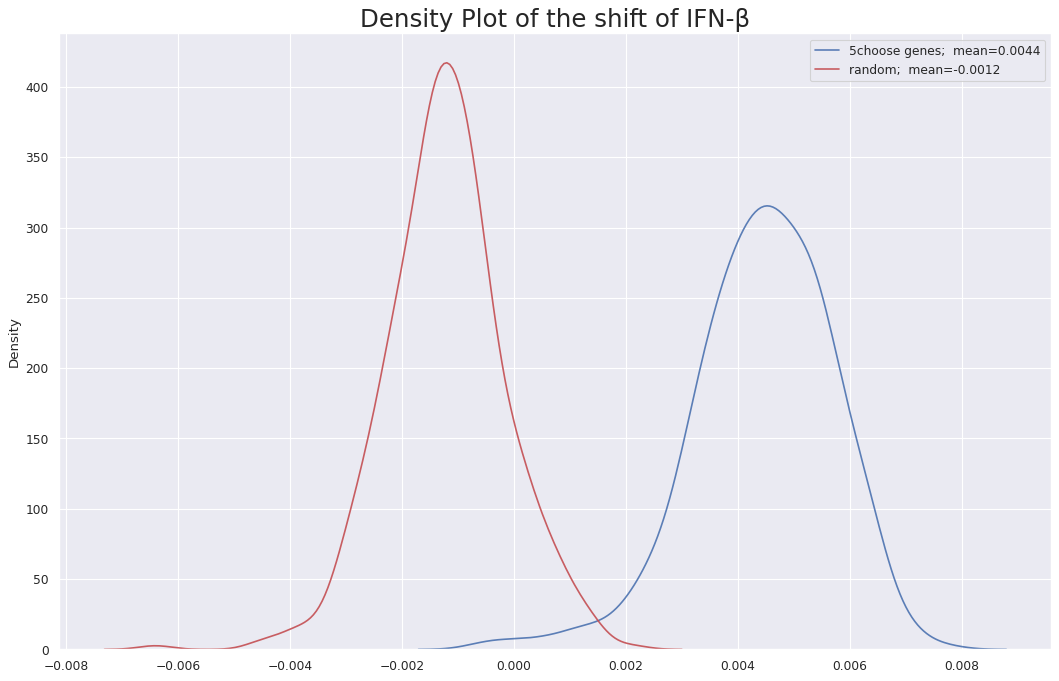

In [171]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16,10), dpi=80)
sns.kdeplot(data = perturb_mean, color='b',label='5choose genes;  mean=0.0044',alpha=.9)
sns.kdeplot(data = random_mean, color='r',label='random;  mean=-0.0012',alpha=.9)

plt.title('Density Plot of the shift of IFN-β', fontsize=22)
#plt.xlim(-0.07,0.07)
plt.legend()
plt.show()